<a href="https://colab.research.google.com/github/DanielO1006/GNURADIO_LABCOMUIS_2024_2_B1A_grupo_1/blob/main/Red_Neuronal_Se%C3%B1ales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

In [ ]:
! unzip /content/speech-emotion-recognition-en.zip

In [3]:
RAVDESS = "/content/Ravdess/audio_speech_actors_01-24"
CREMA = "/content/Crema"
TESS = "/content/Tess"
SAVEE = "/content/Savee"

In [4]:
import os
import pandas as pd

In [ ]:
final_df = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)
final_df.shape
final_df.head()

In [ ]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [ ]:
def plot_distribution(df):
    countTable = df.groupby(['emotion']).count()
    pivotTable = countTable.pivot_table(index='emotion',values='path')

    pivotTable.plot(kind='bar', figsize=(10, 5), color=['orange', 'blue'])
    plt.title('Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('Count')

    # Display the plot
    plt.show()

# Assuming df is your DataFrame
plot_distribution(final_df)
print(final_df.emotion.value_counts())

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment, effects
import numpy as np

In [ ]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)

    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [ ]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2,
    'angry'   : 3,
    'fear'    : 4,
    'disgust' : 5,
    'surprise': 6
}

def encode(label):
    return emotion_dic.get(label)

In [ ]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in final_df.itertuples(index=False):
    try:
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

In [ ]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.5, random_state=1)

y_train_class = to_categorical(y_train, 7)
y_val_class = to_categorical(y_val, 7)

In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(256,return_sequences=True,input_shape=(X_train.shape[1:3])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.2
model_lstm.add(LSTM(64,return_sequences=True))
#model.add(Dropout(0.2))
model_lstm.add(LSTM(32,return_sequences=True))
model_lstm.add(Flatten())
#model.add(Dropout(0.3))
# model_lstm.add(LSTM(128))
#model.add(Dropout(0.3))
model_lstm.add(Dense(7,activation = 'softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_lstm.fit(X_train, y_train_class, batch_size=64, epochs=40, validation_data=(X_val, y_val_class))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

23/23 [==============================] - 17s 677ms/step
Test Accuracy: 0.7984
Test Precision: 0.8026
Test Recall: 0.7984
Test F1-score: 0.7987


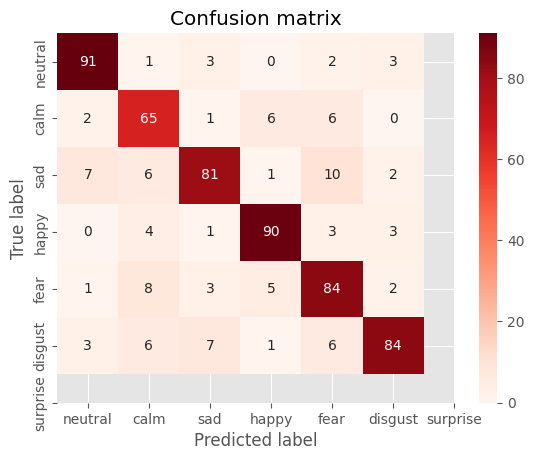

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

y_test_class = to_categorical(y_test, 7)

y_pred = np.argmax(model_lstm.predict(X_test), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust', 'surprise']
cm = confusion_matrix(np.argmax(y_test_class, axis=1), y_pred, labels=range(6))

# Calculate evaluation metrics
accuracy_test = accuracy_score(np.argmax(y_test_class, axis=1), y_pred)
precision_test = precision_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')
recall_test = recall_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')
f1_test = f1_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')

# Print or display the evaluation metrics
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1-score: {f1_test:.4f}')

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
import tensorflow.keras.layers as L

model_cnn = Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1:3])),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])

In [ ]:
model_cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
history=model_cnn.fit(X_train, y_train_class, epochs=50, validation_data=(X_val, y_val_class), batch_size=64)

Epoch 1/50
54/54 [==============================] - 17s 76ms/step - loss: 1.8411 - accuracy: 0.3981 - val_loss: 11.3350 - val_accuracy: 0.1799
Epoch 2/50
54/54 [==============================] - 3s 51ms/step - loss: 1.1501 - accuracy: 0.5866 - val_loss: 3.9596 - val_accuracy: 0.3063
Epoch 3/50
54/54 [==============================] - 3s 51ms/step - loss: 0.9152 - accuracy: 0.6776 - val_loss: 2.0791 - val_accuracy: 0.3654
Epoch 4/50
54/54 [==============================] - 3s 56ms/step - loss: 0.7958 - accuracy: 0.7187 - val_loss: 1.2391 - val_accuracy: 0.5879
Epoch 5/50
54/54 [==============================] - 3s 60ms/step - loss: 0.7583 - accuracy: 0.7340 - val_loss: 0.9337 - val_accuracy: 0.6964
Epoch 6/50
54/54 [==============================] - 3s 52ms/step - loss: 0.6681 - accuracy: 0.7638 - val_loss: 0.7808 - val_accuracy: 0.7005
Epoch 7/50
54/54 [==============================] - 3s 52ms/step - loss: 0.6427 - accuracy: 0.7741 - val_loss: 0.8485 - val_accuracy: 0.7115
Epoch 8/50


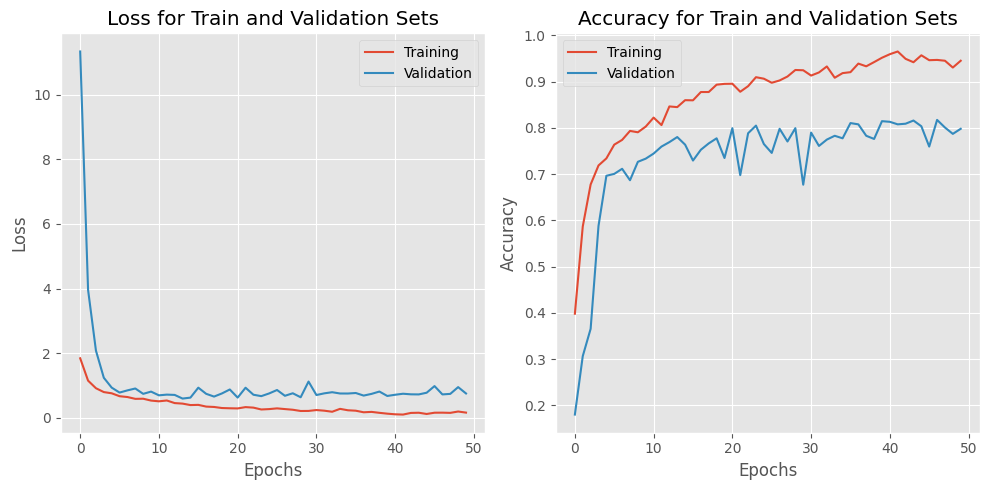

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

23/23 [==============================] - 1s 21ms/step
Test Accuracy: 0.8464
Test Precision: 0.8488
Test Recall: 0.8464
Test F1-score: 0.8467


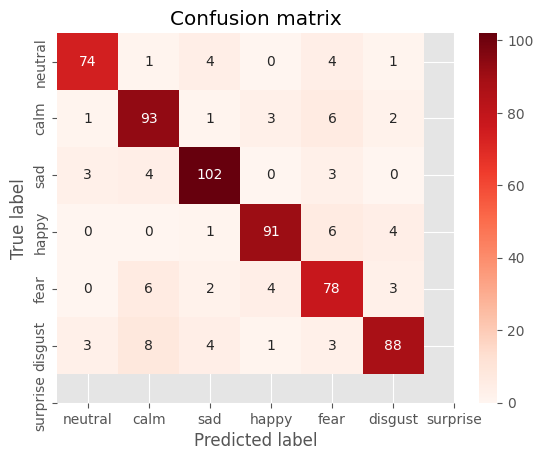

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

y_test_class = to_categorical(y_test, 7)

y_pred = np.argmax(model_cnn.predict(X_test), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust', 'surprise']
cm = confusion_matrix(np.argmax(y_test_class, axis=1), y_pred, labels=range(6))

# Calculate evaluation metrics
accuracy_test = accuracy_score(np.argmax(y_test_class, axis=1), y_pred)
precision_test = precision_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')
recall_test = recall_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')
f1_test = f1_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')

# Print or display the evaluation metrics
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1-score: {f1_test:.4f}')

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

# Define model
model_clstm = Sequential()

model_clstm.add(Conv1D(1024, kernel_size=7, strides=2, padding='same', activation='relu', input_shape=(X_train.shape[1:3])))
model_clstm.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model_clstm.add(BatchNormalization())
model_clstm.add(Dropout(0.3))

model_clstm.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model_clstm.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model_clstm.add(BatchNormalization())
model_clstm.add(Dropout(0.3))

model_clstm.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model_clstm.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model_clstm.add(BatchNormalization())
model_clstm.add(Dropout(0.3))

model_clstm.add(LSTM(128, return_sequences=True))
model_clstm.add(Dropout(0.3))

model_clstm.add(Dense(64, activation='relu'))
model_clstm.add(Flatten())
model_clstm.add(Dense(7, activation='softmax'))

model_clstm.summary()

model_clstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_clstm.fit(X_train, y_train_class, batch_size=64, epochs=40, validation_data=(X_val, y_val_class))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 176, 1024)         108544    
                                                                 
 max_pooling1d (MaxPooling1  (None, 88, 1024)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 88, 1024)          4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 88, 1024)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 88, 512)           2621952   
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 512)           0

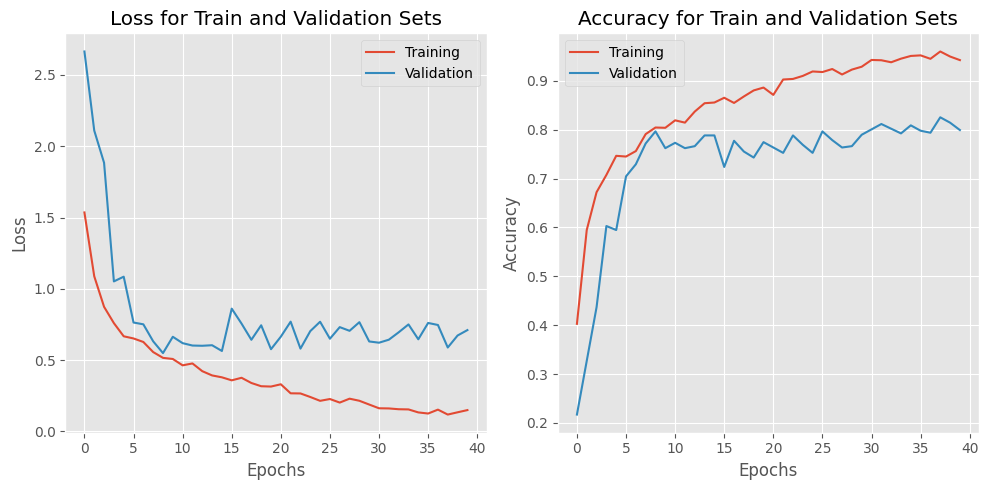

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

23/23 [==============================] - 7s 323ms/step
Test Accuracy: 0.8162
Test Precision: 0.8252
Test Recall: 0.8162
Test F1-score: 0.8168


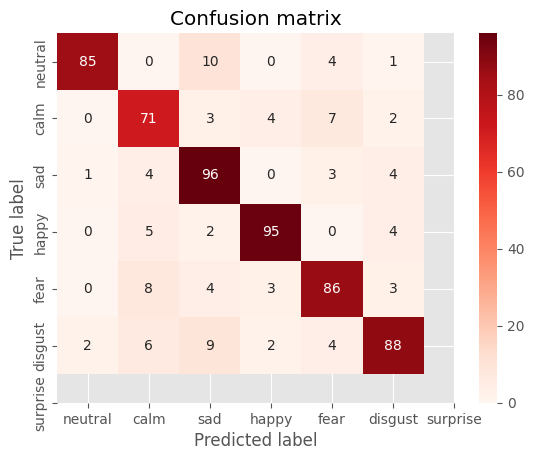

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

y_test_class = to_categorical(y_test, 7)

y_pred = np.argmax(model_clstm.predict(X_test), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust', 'surprise']
cm = confusion_matrix(np.argmax(y_test_class, axis=1), y_pred, labels=range(6))

# Calculate evaluation metrics
accuracy_test = accuracy_score(np.argmax(y_test_class, axis=1), y_pred)
precision_test = precision_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')
recall_test = recall_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')
f1_test = f1_score(np.argmax(y_test_class, axis=1), y_pred, average='weighted')

# Print or display the evaluation metrics
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1-score: {f1_test:.4f}')

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
# Save the trained model
model_clstm.save('model_clstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
